In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vehicle-detection-image-set/data/vehicles/right (28).png
/kaggle/input/vehicle-detection-image-set/data/vehicles/4353.png
/kaggle/input/vehicle-detection-image-set/data/vehicles/5511.png
/kaggle/input/vehicle-detection-image-set/data/vehicles/2664.png
/kaggle/input/vehicle-detection-image-set/data/vehicles/2539.png
/kaggle/input/vehicle-detection-image-set/data/vehicles/5703.png
/kaggle/input/vehicle-detection-image-set/data/vehicles/1231.png
/kaggle/input/vehicle-detection-image-set/data/vehicles/1017.png
/kaggle/input/vehicle-detection-image-set/data/vehicles/4803.png
/kaggle/input/vehicle-detection-image-set/data/vehicles/left (153).png
/kaggle/input/vehicle-detection-image-set/data/vehicles/middle (34).png
/kaggle/input/vehicle-detection-image-set/data/vehicles/left (564).png
/kaggle/input/vehicle-detection-image-set/data/vehicles/2437.png
/kaggle/input/vehicle-detection-image-set/data/vehicles/3217.png
/kaggle/input/vehicle-detection-image-set/data/vehicles/5695.png


In [2]:
maindir = "../input/vehicle-detection-image-set/data"
os.listdir(maindir)

['vehicles', 'non-vehicles']

In [3]:
vehicle_dir = "../input/vehicle-detection-image-set/data/vehicles"
nonvehicle_dir = "../input/vehicle-detection-image-set/data/non-vehicles"
vehicle = os.listdir(maindir+"/vehicles")
non_vehicle = os.listdir(maindir+"/non-vehicles")

print(f"Number of Vehicle Images: {len(vehicle)}")
print(f"Number of Non Vehicle Images: {len(non_vehicle)}")

Number of Vehicle Images: 8792
Number of Non Vehicle Images: 8968


> Sample of Train Images:

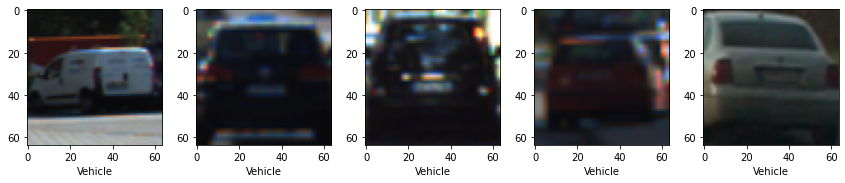

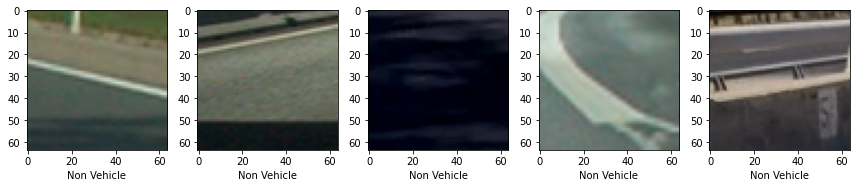

In [4]:
plt.figure(figsize=(12,9))
import cv2
vehicle_img = np.random.choice(vehicle,5)
nonvehicle_img = np.random.choice(non_vehicle,5)
for i in range(5):
    plt.subplot(1,5,i+1)
    img = cv2.imread(vehicle_dir+'/'+vehicle_img[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel("Vehicle")
    #plt.axis("off")
    plt.tight_layout()
    plt.imshow(img)
plt.show()
plt.figure(figsize=(12,9)) 
for i in range(5):
    plt.subplot(1,5,i+1)
    img = cv2.imread(nonvehicle_dir+'/'+nonvehicle_img[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel("Non Vehicle")
    #plt.axis("off")
    plt.imshow(img)
plt.tight_layout()
plt.show()

> Converting Images into Array:

In [5]:
train = []
label = []
import tqdm
from tensorflow.keras.preprocessing import image

for i in tqdm.tqdm(vehicle):
    img = cv2.imread(vehicle_dir+'/'+ i)
    img = cv2.resize(img,(150,150))
    train.append(img)
    label.append("Vehicle")
    
for i in tqdm.tqdm(non_vehicle):
    img = cv2.imread(nonvehicle_dir+'/'+ i)
    img = cv2.resize(img,(150,150))
    train.append(img)
    label.append("Non Vehicle")

100%|██████████| 8968/8968 [01:28<00:00, 101.19it/s]


In [6]:
train = np.array(train)
label = np.array(label)
train.shape,label.shape

((17760, 150, 150, 3), (17760,))

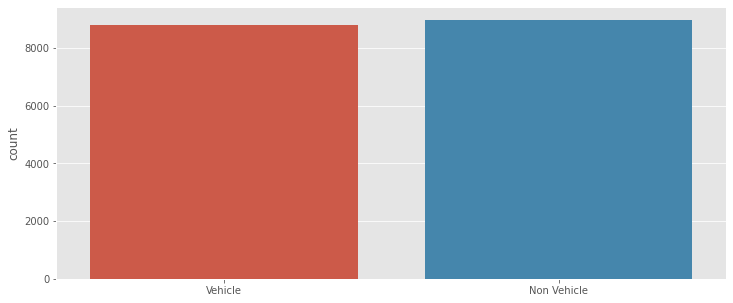

In [7]:
import seaborn as sns
plt.style.use("ggplot")
plt.figure(figsize=(12,5))
sns.countplot(x = label)
plt.show()

- We can see that our data set is balanced. That's good for building a classification model.

In [8]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
le = LabelEncoder()
label= le.fit_transform(label)

In [9]:
label

array([1, 1, 1, ..., 0, 0, 0])

In [10]:
label = to_categorical(label)
print(label.shape)
train,label = shuffle(train, label)

(17760, 2)


> Splitting our Dataset into Train & Test set

In [11]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(train,label,test_size=0.2,random_state = 42)

> I'm going to use EfficientNetB0 model. So let's import the model:

In [12]:
from tensorflow.keras.applications import EfficientNetB0
effnet = EfficientNetB0(weights = "imagenet",include_top = False,input_shape=(150,150,3))

16711680/16705208 [==============================] - 0s 0us/step


> Model Building & Training:

In [13]:
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Conv2D, MaxPooling2D,GlobalAveragePooling2D,Dropout
model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(2,activation='softmax')(model)

model = Model(inputs = effnet.input, outputs = model)

In [14]:
model.compile(optimizer ="adam", loss = "categorical_crossentropy",metrics = ['accuracy'])

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("vehicle.h5",monitor = "val_accuracy",save_best_only = True, 
                             mode='auto',verbose=1)
earlystop = EarlyStopping(monitor = "val_accuracy", patience = 5,mode='auto',verbose=1)
reducelr = ReduceLROnPlateau(monitor = "val_accuracy",factor = 0.3, patience = 3,
                            min_delta = 0.001,mode = 'auto',verbose=1)

In [16]:
history  = model.fit(x_train,y_train, epochs = 10,batch_size=32, validation_data = (x_test,y_test),
                    verbose = 1, callbacks = [checkpoint, earlystop,reducelr])

Epoch 1/10
444/444 [==============================] - 85s 152ms/step - loss: 0.0529 - accuracy: 0.9772 - val_loss: 0.0463 - val_accuracy: 0.9969

Epoch 00001: val_accuracy improved from -inf to 0.99690, saving model to vehicle.h5
Epoch 2/10
444/444 [==============================] - 68s 152ms/step - loss: 0.0148 - accuracy: 0.9956 - val_loss: 0.0012 - val_accuracy: 1.0000

Epoch 00002: val_accuracy improved from 0.99690 to 1.00000, saving model to vehicle.h5
Epoch 3/10
444/444 [==============================] - 68s 153ms/step - loss: 0.0051 - accuracy: 0.9984 - val_loss: 0.0041 - val_accuracy: 0.9977

Epoch 00003: val_accuracy did not improve from 1.00000
Epoch 4/10
444/444 [==============================] - 68s 153ms/step - loss: 0.0058 - accuracy: 0.9979 - val_loss: 0.0240 - val_accuracy: 0.9927

Epoch 00004: val_accuracy did not improve from 1.00000
Epoch 5/10
444/444 [==============================] - 68s 153ms/step - loss: 0.0038 - accuracy: 0.9987 - val_loss: 0.0054 - val_accurac

In [17]:
model.evaluate(x_test,y_test)

111/111 [==============================] - 3s 30ms/step - loss: 4.9146e-04 - accuracy: 0.9997


[0.0004914638120681047, 0.9997184872627258]

In [18]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis=1)
y_pred[:15]

array([0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1])

In [19]:
y_test = np.argmax(y_test,axis=1)
y_test[:15]

array([0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1])

> Classification Report:

In [20]:
from sklearn.metrics import accuracy_score, classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1848
           1       1.00      1.00      1.00      1704

    accuracy                           1.00      3552
   macro avg       1.00      1.00      1.00      3552
weighted avg       1.00      1.00      1.00      3552



> Confusion Matrix:

(<Figure size 576x504 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

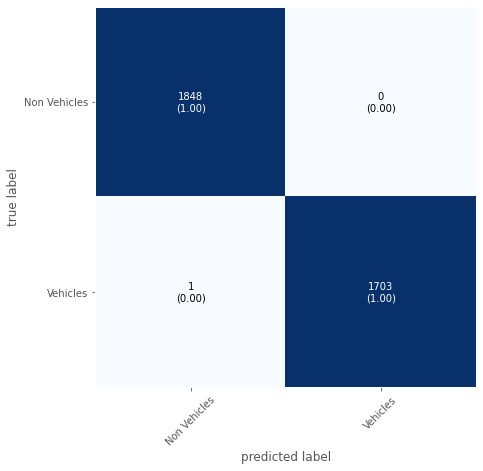

In [21]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names =['Non Vehicles', 'Vehicles'],
                     show_normed = True)

> Learning Curve:

In [23]:
# plt.figure(figsize = (12,6))
# epochs = range(1,11)
# plt.subplot(1,2,1)
# plt.plot(epochs,history.history['accuracy'],'go--')
# plt.plot(epochs,history.history['val_accuracy'],'ro--')
# plt.title("Model Accuracy")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend(['Train', 'Val'],loc ='upper left')

# plt.subplot(1,2,2)
# plt.plot(epochs,history.history['loss'],'go--')
# plt.plot(epochs,history.history['val_loss'],'ro--')
# plt.title("Model Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend(['Train', 'Val'],loc ='upper left')
# plt.show()

> Actual vs Predicted Result:

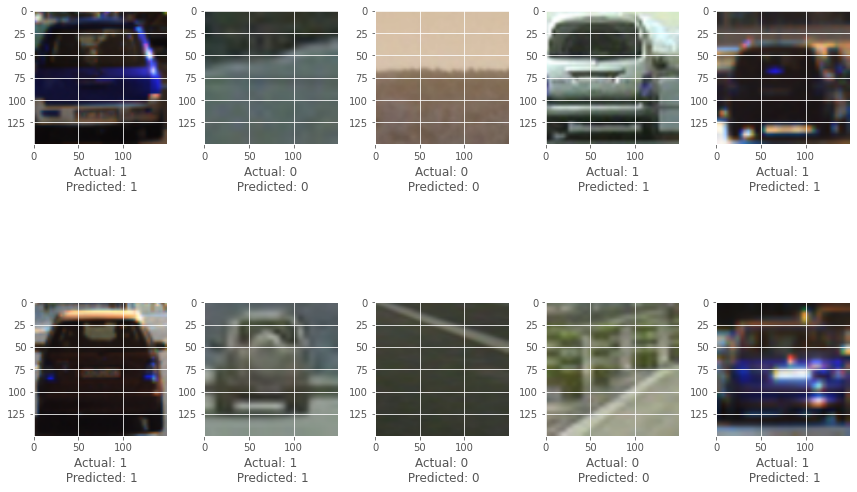

In [25]:
plt.figure(figsize=(12,9))
for i in range(10):
    sample_idx = np.random.choice(range(len(x_test)))
    plt.subplot(2,5,i+1)
    plt.imshow(x_test[sample_idx])
    plt.xlabel(f"Actual: {y_test[sample_idx]}\n Predicted: {y_pred[sample_idx]}")
    
plt.tight_layout()
plt.show()